In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
!pip install nilearn --quiet
from nilearn import plotting, datasets
from nilearn import datasets
from nilearn import input_data
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting

/root/venv/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
#@title Default title text
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}



In [5]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/2y3fw/download
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

subjects = np.loadtxt(os.path.join(HCP_DIR,'subjects_list.txt'),dtype='str')
subjects = [i for i in subjects if i.startswith('.') == False]
subjects[:10]

['100307',
 '100408',
 '101915',
 '102816',
 '103414',
 '103515',
 '103818',
 '105115',
 '105216',
 '106016']

In [6]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

print(type(region_info['network']),region_info['network'].shape)
print(region_info['name'][0:5], len(region_info['name']))

print(region_info['network'][0:5])

<class 'numpy.ndarray'> (360,)
['R_V1', 'R_MST', 'R_V6', 'R_V2', 'R_V3'] 360
['Visual1' 'Visual2' 'Visual2' 'Visual2' 'Visual2']


In [7]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment 
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [8]:
network_dict = {1: 'Visual1', 
       2: 'Visual2', 
       3:'Somatomotor',
       4:'Cingulo-Oper',
       5:'Language',
       6:'Default',
       7:'Frontopariet',
       8:'Auditory',
       9:'Posterior-Mu',
       10:'Dorsal-atten',
       11:'Ventral-Mult',
       12:'Orbito-Affec'}

In [9]:
my_exp  = 'RELATIONAL'
my_subj = subjects[0]
my_run  = 1

data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)

print(type(data), data.shape) #(number of regions x number of time points)
data_reshape = data.T
data_reshape.shape
data

df = pd.DataFrame(data)

df.insert(0, "region_network", region_info['network'], True)

df.insert(1,'region_name',region_info['name'], True)
  
df

<class 'numpy.ndarray'> (360, 232)


,region_network,region_name,0,1,2,3,4,5,6,7,...,222,223,224,225,226,227,228,229,230,231
0,Visual1,R_V1,-48.189824,-123.183329,-111.636163,-94.866227,-146.742217,-80.721009,-77.920675,-56.908539,...,-86.747537,-92.660483,-92.647225,-95.007593,-70.466987,-82.325414,-96.089391,-111.200650,-118.098872,-99.456190
1,Visual2,R_MST,-103.330179,-81.796385,11.049421,-17.440904,-54.132053,-50.394157,-92.923544,-49.076337,...,24.412676,10.107166,22.859454,-24.822637,45.909207,25.870453,24.988424,26.599945,34.553250,10.490210
2,Visual2,R_V6,8.230368,-41.579313,-64.025063,-92.431567,-152.969065,-122.173540,-102.993098,-137.123195,...,67.736235,42.688003,49.376027,39.188312,29.658523,46.003726,2.645201,-17.484754,27.848731,29.593713
3,Visual2,R_V2,-39.885414,-56.938763,-28.784178,-77.321723,-77.652827,-68.319306,-39.959312,-31.860840,...,-72.800605,-70.644900,-65.084300,-63.699210,-71.076126,-67.680887,-59.432308,-76.308464,-70.647900,-54.320524
4,Visual2,R_V3,-35.207058,-103.530630,-66.873357,-95.814135,-83.471385,-45.253579,-52.897172,-50.724502,...,-44.314806,-39.730976,-53.421475,-63.394721,-13.439412,-26.120324,-25.618079,-35.641966,-9.505852,-9.807686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Posterior-Mu,L_STSva,107.984922,34.781199,74.950061,-5.356716,79.945171,21.011335,47.814796,42.449002,...,-6.259771,-47.783224,-26.398117,-2.050385,-7.111788,0.364086,13.609847,-8.334277,10.378189,58.098567
356,Frontopariet,L_TE1m,20.085174,67.122965,-28.731517,8.646173,-22.979730,76.810660,56.610271,61.340564,...,24.883040,41.853238,-2.066290,50.957477,-7.743095,28.714808,-34.446026,-31.107497,-30.310680,-49.647444
357,Cingulo-Oper,L_PI,77.230816,124.022132,-48.637881,-1.545822,9.052992,57.409129,65.298026,58.165003,...,-92.161154,-24.976298,13.367422,-47.056263,40.882769,-14.641187,22.448935,-30.245754,2.365296,82.537479
358,Cingulo-Oper,L_a32pr,49.434549,-24.636511,-82.121337,-16.353797,-60.678977,-0.614691,-5.457091,-44.252959,...,-63.385474,-30.917525,-51.549643,-96.721175,-64.299254,27.301545,32.799157,-26.964553,-80.570845,-112.689322


In [10]:
data_Frontopariet = df[df["region_network"] == 'Frontopariet']
data_Frontopariet
front_labels = data_Frontopariet['region_name']
front_labels
labels = front_labels.to_numpy()

In [11]:
labels

array(['R_RSC', 'R_POS2', 'R_7Pm', 'R_8BM', 'R_8C', 'R_a47r', 'R_IFJp',
       'R_IFSa', 'R_p9-46v', 'R_a9-46v', 'R_a10p', 'R_11l', 'R_13l',
       'R_i6-8', 'R_s6-8', 'R_AVI', 'R_TE1p', 'R_IP2', 'R_IP1', 'R_PFm',
       'R_p10p', 'R_p47r', 'L_RSC', 'L_POS2', 'L_7Pm', 'L_33pr', 'L_d32',
       'L_8BM', 'L_8C', 'L_44', 'L_a47r', 'L_IFJp', 'L_IFSp', 'L_p9-46v',
       'L_a9-46v', 'L_a10p', 'L_11l', 'L_13l', 'L_OFC', 'L_i6-8',
       'L_s6-8', 'L_AVI', 'L_TE1p', 'L_IP2', 'L_IP1', 'L_PFm', 'L_31a',
       'L_p10p', 'L_p47r', 'L_TE1m'], dtype=object)

In [12]:
df_front = data_Frontopariet.drop(columns=['region_network', 'region_name'])

In [13]:
df_front = df_front.to_numpy()

In [14]:
df_front

array([[162.48646368,   2.47708699, 142.49382383, ...,  32.39468371,
         42.27363647,   7.47139672],
       [ 52.5311888 ,  25.15320833, -10.0484323 , ...,  34.72496223,
         33.06713802,  47.84854817],
       [  0.1728727 , -57.45880048,  12.72390317, ..., -31.5583183 ,
         28.48860756,  49.6120003 ],
       ...,
       [107.77941141, 169.43048563,  -2.53277787, ...,  98.19658115,
         92.88671787,  95.77513229],
       [ 88.96334569, -61.63227416, -72.00383727, ...,  17.95347408,
        -16.34384756,  33.79376447],
       [ 20.08517446,  67.12296479, -28.73151662, ..., -31.10749678,
        -30.31068042, -49.64744369]])

In [15]:
my_exp  = 'RELATIONAL'
my_run  = 1
my_subj = subjects[1]

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([df_front.T])[0]

print(type(df_front), df_front.shape) #(number of regions x number of time points)

<class 'numpy.ndarray'> (50, 232)


In [16]:
print(type(correlation_matrix))

<class 'numpy.ndarray'>


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


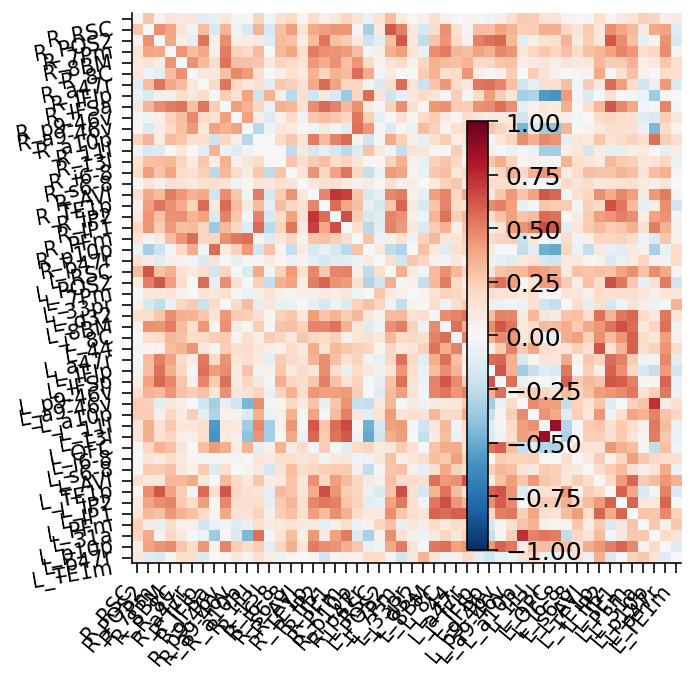

In [17]:
# Display the correlation matrix
import numpy as np
from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True, vmax=1,vmin=-1)

In [18]:
def get_cond_evs(cond_name, task_name, subject, run = 1):
  """Load onset files for a single condition from a task.
  
  Args:
    cond_name (str): condition name pulled from the conditions_dict for task_name
    task_name (str): task name instead of the bold run
    subject (int): 0-based subject ID to load
    run (int): 1 or 2 for task runs (use run-1 for indexing)

  Returns
    cond_evs (n_blocks x 3): Events file for single condition to be formatted for design matrix

  """
  bold_name = bold_name_dict[task_name][run-1]
  cond_evs = pd.read_csv('%s/subjects/%s/EVs/%s/%s.txt'%(HCP_DIR, subject, bold_name, cond_name), sep="\t", header=None)
  cond_evs = cond_evs.rename(columns={0: "Onset", 1: "Duration", 2: "amplitude"})
  cond_evs = cond_evs.drop(columns=['amplitude'])
  cond_evs['Stim'] = cond_name

  return cond_evs

def get_run_evs(subject, task_name, run = 1):
  """Load onset files for a full file.
  
  Args:
    task_name (str): task name instead of the bold run
    subject (int): 0-based subject ID to load
    run (int): 1 or 2 for task runs (use run-1 for indexing)

  Returns
    evs (n_blocks for run x 3 array): Events file for single condition to be formatted for design matrix

  """

  conditions = EXPERIMENTS[task_name]

  evs = pd.DataFrame()

  for cond in conditions:
    cond_evs = get_cond_evs(cond, task_name, subject, run)
    evs = evs.append(cond_evs)
  
  evs = evs.sort_values(by="Onset") 

  return evs

def run_evs_to_dm(run_evs, task_name, TR=.72, convolve = True, add_poly = 2, dct_basis=False):

  sampling_freq = 1./TR
  run_length = run_length_dict[task_name]
  dm = onsets_to_dm(run_evs, sampling_freq=sampling_freq, run_length=run_length, sort=True, add_poly=add_poly)

  if convolve: 
    dm = dm.convolve()

  if dct_basis:
    dm = dm.add_dct_basis()

  return dm

def get_task_dms(subject, task_name, TR = .72, convolve = True, add_poly = 2, dct_basis=False):

  runs = list(range(1,len(task_run_dict[task_name])+1))
  task_dm = Design_Matrix(sampling_freq=1./TR)

  for run in runs:
    run_evs = get_run_evs(subject=subject, task_name=task_name, run=run)
    run_dm = run_evs_to_dm(run_evs=run_evs, task_name=task_name, add_poly=add_poly, dct_basis=dct_basis)
    task_dm = task_dm.append(run_dm)

  return task_dm

def load_run_timeseries(subject, task_name, run = 1, remove_mean=True, scale_ts=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    task_name (str): task name instead of the bold run
    run (int): 1 or 2 for task runs
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run = task_run_dict[task_name][run-1]

  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)

  if scale_ts:
    #scales each parcel's timeseries (instead of scaling the bold for one 1 TR from all parcels)
    ts = scale(ts, axis=1)
  return ts

def load_task_timeseries(subject, task_name, remove_mean=True, scale_ts = True):
  
  runs = list(range(1,len(task_run_dict[task_name])+1))
  task_ts = np.empty((360, 0))

  for run in runs:
    #since everything is loaded by run and scale_ts is true each parcel should be 
    #scaled for each parcel and for each run separately before being concatenated together
    cur_run_ts = load_run_timeseries(subject=subject, task_name=task_name, run=run)
    task_ts = np.append(task_ts, cur_run_ts, axis=1)
  
  return task_ts

def get_sub_task_resids(subject, task_name):
 
  #load task data
  task_ts = load_task_timeseries(subject=subject, task_name=task_name)

  #make design matrix
  task_dm = get_task_dms(subject=subject, task_name=task_name)

  #initialize empty variables to store data in
  run_length = run_length_dict[task_name]
  num_runs = len(task_run_dict[task_name])
  resids = np.empty((0, num_runs*run_length))

  #loop through parcels, run regression and extract residuals
  for parcel in range(len(task_ts)):
    model = sm.OLS(task_ts[parcel], task_dm)
    results = model.fit()
    cur_resids = np.array([results.resid])
    resids = np.append(resids, cur_resids, axis=0)

  #store parcel residuals in same format as original BOLD
  out_dir = './hcp/residuals/%s'%(task_name)
  if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

  out_fn = '%s_%s_Glasser360Cortical.npy'%(task_name, str(subject))

  np.save(os.path.join(out_dir, out_fn), resids)

  return resids

def load_fcs(task_name, fc_type):
  
  base_dir = '/content/drive/My Drive/Colab Notebooks'

  if fc_type == "resid":
    fc_dir = os.path.join(base_dir, 'residual_fcs')
  
  elif fc_type == "task":
    fc_dir = os.path.join(base_dir, 'task_preds_fcs')

  elif fc_type == "rest":
    fc_dir = os.path.join(base_dir, 'rest_fcs')

  input_dir = os.path.join(fc_dir, task_name)
  fcs_list = os.listdir(input_dir)
  fcs = np.zeros((360, 360, len(fcs_list)))

  for i, fc in enumerate(fcs_list):
    fcs[:,:,i] = np.load(os.path.join(input_dir, fc))

  return fcs

def get_sub_task_pred(subject, task_name):
 
  #load task data
  task_ts = load_task_timeseries(subject=subject, task_name=task_name)

  #make design matrix
  task_dm = get_task_dms(subject=subject, task_name=task_name)
  task_regs = task_dm.iloc[:,:len(conditions_dict[task_name])]

  #initialize empty variables to store data in
  run_length = run_length_dict[task_name]
  num_runs = len(task_run_dict[task_name])
  preds = np.empty((0, num_runs*run_length))

  #loop through parcels, run regression and extract residuals
  for parcel in range(len(task_ts)):
    model = sm.OLS(task_ts[parcel], task_dm)
    results = model.fit()
    task_coefs = results.params[:len(conditions_dict[task_name])]
    cur_preds = np.zeros(num_runs*run_length)
    for i in range(len(conditions_dict['emotion'])):
      cur_preds += task_coefs[i]*task_regs.iloc[:,i]
    cur_preds = np.array(cur_preds).reshape(1, -1)
    preds = np.append(preds, cur_preds, axis=0)

  #store parcel residuals in same format as original BOLD
  out_dir = './hcp/task_preds/%s'%(task_name)
  if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

  out_fn = '%s_%s_Glasser360Cortical.npy'%(task_name, str(subject))

  np.save(os.path.join(out_dir, out_fn), preds)

  return preds

In [19]:
subjects[0]
len(subjects)
range(len(subjects))

range(0, 100)

In [20]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# ConenctivityMeasure from Nilearn uses simple 'correlation' to compute
# connectivity matrices for all subjects in a list
connectome_measure = ConnectivityMeasure(kind='correlation')

# useful for plotting connectivity interactions on glass brain
from nilearn import plotting

In [22]:
my_exp  = 'RELATIONAL'
my_run  = 1

correlation_measure = ConnectivityMeasure(kind='correlation')
data = []
correlation_matrix = []

  my_subj = subjects[i]
  data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
  correlation_matrix{i} = correlation_measure.fit_transform([data[i].T])

print(type(data), data.shape) #(number of regions x number of time points)

IndentationError: unexpected indent (2551996532.py, line 8)

In [ ]:


# Display the correlation matrix
import numpy as np
from nilearn import plotting
# Mask out the major diagonal
labels = region_info['name']
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True,
                     vmax=1, vmin=-1)

In [ ]:
labels = region_info['network']
labels

array(['Visual1', 'Visual2', 'Visual2', 'Visual2', 'Visual2', 'Visual2',
       'Visual2', 'Somatomotor', 'Somatomotor', 'Cingulo-Oper',
       'Language', 'Default', 'Visual2', 'Frontopariet', 'Frontopariet',
       'Visual2', 'Visual2', 'Visual2', 'Visual2', 'Visual2', 'Visual2',
       'Visual2', 'Visual2', 'Auditory', 'Default', 'Default',
       'Dorsal-atten', 'Default', 'Frontopariet', 'Posterior-Mu',
       'Posterior-Mu', 'Posterior-Mu', 'Posterior-Mu', 'Posterior-Mu',
       'Posterior-Mu', 'Somatomotor', 'Cingulo-Oper', 'Cingulo-Oper',
       'Somatomotor', 'Somatomotor', 'Somatomotor', 'Somatomotor',
       'Cingulo-Oper', 'Cingulo-Oper', 'Cingulo-Oper', 'Language',
       'Somatomotor', 'Visual2', 'Visual2', 'Language', 'Somatomotor',
       'Somatomotor', 'Somatomotor', 'Somatomotor', 'Somatomotor',
       'Somatomotor', 'Cingulo-Oper', 'Cingulo-Oper', 'Cingulo-Oper',
       'Cingulo-Oper', 'Posterior-Mu', 'Posterior-Mu', 'Frontopariet',
       'Posterior-Mu', 'Posterior-

In [ ]:
my_exp  = 'RELATIONAL'
my_run  = 1

data_all = []
#for i in range(len(subjects)):
my_subj = subjects[1]
data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
  #data_all.append(data)

print(data.shape)

In [ ]:
pd.DataFrame({'name' : region_info['name'],
              'network'     : region_info['network'],
              wdata})

In [ ]:
data_target = data
for i in ['L_V3A', 'L_RSC', 'L_POS2', 'L_V7', 'L_IPS1']:
  

In [ ]:
correlation_matrices = connectome_measure.fit_transform([data.T])
#mean_correlation_matrix = connectome_measure.mean_

#data_all.reshape()

print(correlation_matrices.shape)

#url = ("https://gist.githubusercontent.com/mwaskom/cb78082d7eede47bed54866fd8cb06b3/raw/9c39627d84c20e65101fff49fe67adb76d6e4155/glasser_coords.txt")
#coordinates = np.loadtxt(url)

## plot connectome with 80% edge strength in the connectivity
#plotting.plot_connectome(mean_correlation_matrix, coordinates, edge_threshold="80%")
#print(correlation_matrices.shape)

#plotting.plot_matrix(mean_correlation_matrix, vmin=-1)
#plotting.show()
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True,
                     vmax=1, vmin=-1)

In [ ]:
print(labels)

In [ ]:
url = ("https://gist.githubusercontent.com/mwaskom/cb78082d7eede47bed54866fd8cb06b3/raw/9c39627d84c20e65101fff49fe67adb76d6e4155/glasser_coords.txt")
coords = np.loadtxt(url)
connectivity_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = connectivity_measure.fit_transform([data.T])[0]
#print(correlation_matrix)
print(data.shape)

# Plot connectivity matrix (use plot_matrix)
plotting.plot_matrix(correlation_matrix, vmin=-1)
plotting.show()
print(correlation_matrix.shape)

In [ ]:
plotting.view_connectome (correlation_matrix, coords, edge_threshold="99%")

In [ ]:
mean_correlation_matrix = connectivity_measure.mean_
plotting.plot_connectome(mean_correlation_matrix, coords,
                         edge_threshold="80%")

In [ ]:
from nilearn.glm.first_level import make_first_level_design_matrix
design_matrices = make_first_level_design_matrix(frame_times, events,
                          drift_model='polynomial', drift_order=3)

In [ ]:
timeseries_relational = []
#for subject in subjects:
ts_concat = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
timeseries_relational.append(ts_concat)


In [ ]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_relational):
  fc[sub] = np.corrcoef(ts)
group_fc = fc.mean(axis=0)

#plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
#plt.colorbar()
#plt.show()

plotting.plot_matrix(group_fc, cmap="bwr", vmin=-1,vmax=1)
plotting.show()

In [ ]:
def get_run_evs(subject, task_name, run = 1):
  """Load onset files for a full file.
  
  Args:
    task_name (str): task name instead of the bold run
    subject (int): 0-based subject ID to load
    run (int): 1 or 2 for task runs (use run-1 for indexing)

  Returns
    evs (n_blocks for run x 3 array): Events file for single condition to be formatted for design matrix

  """

  conditions = conditions_dict[task_name]

  evs = pd.DataFrame()

  for cond in conditions:
    cond_evs = get_cond_evs(cond, task_name, subject, run)
    evs = evs.append(cond_evs)
  
  evs = evs.sort_values(by="Onset") 

  return evs
def get_sub_task_pred(subject, task_name):
 
  #load task data
  task_ts = load_task_timeseries(subject=subject, task_name=task_name)

  #make design matrix
  task_dm = get_task_dms(subject=subject, task_name=task_name)
  task_regs = task_dm.iloc[:,:len(conditions_dict[task_name])]

  #initialize empty variables to store data in
  run_length = run_length_dict[task_name]
  num_runs = len(task_run_dict[task_name])
  preds = np.empty((0, num_runs*run_length))

  #loop through parcels, run regression and extract residuals
  for parcel in range(len(task_ts)):
    model = sm.OLS(task_ts[parcel], task_dm)
    results = model.fit()
    task_coefs = results.params[:len(conditions_dict[task_name])]
    cur_preds = np.zeros(num_runs*run_length)
    for i in range(len(conditions_dict['emotion'])):
      cur_preds += task_coefs[i]*task_regs.iloc[:,i]
    cur_preds = np.array(cur_preds).reshape(1, -1)
    preds = np.append(preds, cur_preds, axis=0)

  #store parcel residuals in same format as original BOLD
  out_dir = './hcp/task_preds/%s'%(task_name)
  if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

  out_fn = '%s_%s_Glasser360Cortical.npy'%(task_name, str(subject))

  np.save(os.path.join(out_dir, out_fn), preds)

  return preds

In [ ]:
run_evs = get_run_evs(subject= my_subj, task_name = task_name, run = my_run)
run_evs

In [ ]:
data1 = np.load('/content/hcp/subjects/105216/RELATIONAL/tfMRI_RELATIONAL_RL/data.npy')
print(data1)
data1.shape

In [ ]:
plt.plot(data1)
plt.show()

In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
print(type(evs), len(evs))
print(evs[0]) #match
print(evs[1]) #relation

In [ ]:
# we need a little function that averages all frames from any given condition

def average_frames(data, evs, experiment, cond):    
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)


match_activity = average_frames(data, evs, my_exp, 'match')
relation_activity = average_frames(data, evs, my_exp, 'relation')
contrast = match_activity - relation_activity  
print(match_activity.shape, type(match_activity))

In [ ]:
# Plot activity level in each ROI for both conditions
plt.plot(match_activity,label='match process')
plt.plot(relation_activity,label='relation process')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

In [ ]:
df = pd.DataFrame({'match_activity' : match_activity,
                   'relation_activity' : relation_activity,
                   'name' : region_info['name'],
                   'network'     : region_info['network'],
                   'hemi'        : region_info['hemi']})

fig,(ax1,ax2) = plt.subplots(1,2)
sns.barplot(y='network', x='match_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='relation_activity', data=df, hue='hemi',ax=ax2)

#df_2  = df.loc[(df['network'] == 'Visual2')]

print(df)

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0,1]:
    data = load_single_timeseries(subject=s,experiment=my_exp,run=r,remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    match_activity = average_frames(data, evs, my_exp, 'match')
    relation_activity = average_frames(data, evs, my_exp, 'relation')

    contrast = match_activity - relation_activity
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject


In [ ]:
df = pd.DataFrame({'contrast':group_contrast,'network':region_info['network'],'hemi':region_info['hemi']})
# we will plot the left foot minus right foot contrast so we only need one plot
sns.barplot(y='network', x='contrast', data=df, hue='hemi')

df_match = pd.DataFrame({'match_activity':match_activity,'network':region_info['network'],'hemi':region_info['hemi']})
df_relation = pd.DataFrame({'match_activity':match_activity,'relation_activity':relation_activity, 'network':region_info['network'],'hemi':region_info['hemi']})
#df1 = pd.DataFrame({'match_activity':match_activity,'relation_activity':relation_activity, 'network':region_info['network'],'hemi':region_info['hemi']})
#df1  = df1.loc[(df1['network'] == 'Visual2') & (df1['hemi'] == 'Right')]
#print(df1)
print(type(df_match))

In [ ]:
match_rev = match_activity.reshape(-1,1)

In [ ]:
a = relation_activity - match_rev
a.shape
print(a)

In [ ]:
plt.imshow(a)
plt.show()

In [ ]:
#print(region_info['network'])

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
fig, ax = plt.subplots()

im, cbar = heatmap(a, region_info['network'], region_info['network'], cmap="YlGn")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

In [ ]:
!pip install -U --user nilearn

import nilearn

In [ ]:
import sys
for i in sys.path:print(i)

In [ ]:
sys.path.append('path to your module')


In [ ]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)

In [ ]:
subjects = os.listdir('./hcp_task/subjects')
subjects = [i for i in subjects if i.startswith('.') == False]
subjects[:10]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6295fdfe-0fe7-4eff-a146-eea081f08ccc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>